In [1]:
import keras
from keras.models import Sequential
from keras.models import model_from_json
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.datasets import cifar10
from keras import regularizers
from keras.callbacks import LearningRateScheduler
import numpy as np
from matplotlib import pyplot

In [2]:
def show_imgs(X):
    pyplot.figure(1)
    k = 0
    for i in range(0,3):
        for j in range(0,3):
            pyplot.subplot2grid((3,3),(i,j))
            pyplot.imshow(X[k])
            k = k+1
    pyplot.show()


# EDA

In [37]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

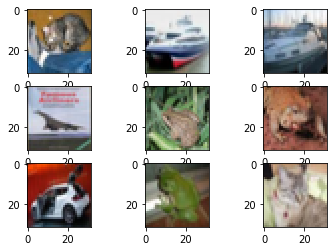

In [38]:
#visualise test data
show_imgs(x_test[:9])

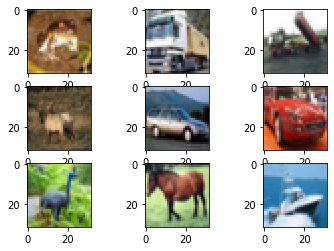

In [39]:
#visualise training data
show_imgs(x_train[:9])

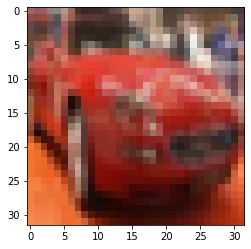

In [40]:
pyplot.imshow(x_train[5])

In [41]:
print('Labels:' , np.unique(y_train))

Labels: [0 1 2 3 4 5 6 7 8 9]


In [42]:
print('X train: ' , x_train.shape)
print('Y train: ' , y_train.shape)
print('X test: ', x_test.shape)
print('Y test: ', y_test.shape)

X train:  (50000, 32, 32, 3)
Y train:  (50000, 1)
X test:  (10000, 32, 32, 3)
Y test:  (10000, 1)


# Preprocessing

In [43]:
#data augmentation and normalization

from keras.preprocessing.image import ImageDataGenerator

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
 
#mean = np.mean(x_train,axis=(0,1,2,3))
#std = np.std(x_train,axis=(0,1,2,3))
#x_train = (x_train-mean)/(std+1e-7)
#x_test = (x_test-mean)/(std+1e-7)
x_train = x_train/255
x_test = x_test/255

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    )
datagen.fit(x_train)

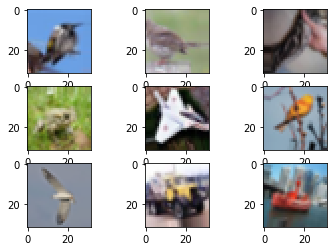

In [44]:
#visualise augmented and normalised training images

from matplotlib import pyplot as plt

for X_batch, y_batch in datagen.flow(x_train, y_train, batch_size=9, shuffle=True):
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i].reshape(32, 32, 3))
    plt.show()
    break

In [45]:
#one hot encode target variable

num_classes = 10
y_train = np_utils.to_categorical(y_train,num_classes)
y_test = np_utils.to_categorical(y_test,num_classes)

In [46]:
y_test[2]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.], dtype=float32)

# Model

In [13]:
def lr_schedule(epoch):
    lrate = 0.001
    if epoch > 65:
        lrate = 0.0005
    if epoch > 85:
        lrate = 0.0003
    return lrate

In [14]:
#model

weight_decay = 1e-4
model = Sequential()

model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Activation('elu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.4))

model.add(Flatten())
model.add(Dense(num_classes, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0

In [19]:
#training
batch_size = 64

opt_rms = keras.optimizers.RMSprop(lr=0.0005,decay=1e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    steps_per_epoch=x_train.shape[0] // batch_size, epochs=125,\
                    verbose=1, validation_data=(x_test,y_test), callbacks=[LearningRateScheduler(lr_schedule)])

Epoch 1/125
781/781 [==============================] - 20s 26ms/step - loss: 1.8038 - accuracy: 0.4415 - val_loss: 1.4988 - val_accuracy: 0.5467 - lr: 0.0010
Epoch 2/125
781/781 [==============================] - 19s 25ms/step - loss: 1.2480 - accuracy: 0.5956 - val_loss: 1.0016 - val_accuracy: 0.6841 - lr: 0.0010
Epoch 3/125
781/781 [==============================] - 21s 27ms/step - loss: 1.0729 - accuracy: 0.6526 - val_loss: 0.9887 - val_accuracy: 0.6984 - lr: 0.0010
Epoch 4/125
781/781 [==============================] - 21s 26ms/step - loss: 0.9817 - accuracy: 0.6884 - val_loss: 0.8575 - val_accuracy: 0.7409 - lr: 0.0010
Epoch 5/125
781/781 [==============================] - 21s 27ms/step - loss: 0.9159 - accuracy: 0.7150 - val_loss: 0.8720 - val_accuracy: 0.7403 - lr: 0.0010
Epoch 6/125
781/781 [==============================] - 21s 27ms/step - loss: 0.8650 - accuracy: 0.7317 - val_loss: 0.8730 - val_accuracy: 0.7505 - lr: 0.0010
Epoch 7/125
781/781 [==============================]

781/781 [==============================] - 22s 28ms/step - loss: 0.6049 - accuracy: 0.8447 - val_loss: 0.7052 - val_accuracy: 0.8192 - lr: 0.0010
Epoch 53/125
781/781 [==============================] - 22s 28ms/step - loss: 0.6047 - accuracy: 0.8463 - val_loss: 0.6336 - val_accuracy: 0.8406 - lr: 0.0010
Epoch 54/125
781/781 [==============================] - 22s 28ms/step - loss: 0.6006 - accuracy: 0.8467 - val_loss: 0.6486 - val_accuracy: 0.8401 - lr: 0.0010
Epoch 55/125
781/781 [==============================] - 22s 28ms/step - loss: 0.5970 - accuracy: 0.8482 - val_loss: 0.5808 - val_accuracy: 0.8593 - lr: 0.0010
Epoch 56/125
781/781 [==============================] - 22s 28ms/step - loss: 0.6006 - accuracy: 0.8457 - val_loss: 0.6183 - val_accuracy: 0.8447 - lr: 0.0010
Epoch 57/125
781/781 [==============================] - 22s 28ms/step - loss: 0.6019 - accuracy: 0.8457 - val_loss: 0.6281 - val_accuracy: 0.8463 - lr: 0.0010
Epoch 58/125
781/781 [==============================] - 22s

781/781 [==============================] - 22s 28ms/step - loss: 0.4118 - accuracy: 0.8937 - val_loss: 0.4513 - val_accuracy: 0.8888 - lr: 3.0000e-04
Epoch 103/125
781/781 [==============================] - 22s 28ms/step - loss: 0.4231 - accuracy: 0.8895 - val_loss: 0.4775 - val_accuracy: 0.8812 - lr: 3.0000e-04
Epoch 104/125
781/781 [==============================] - 22s 28ms/step - loss: 0.4152 - accuracy: 0.8914 - val_loss: 0.4391 - val_accuracy: 0.8899 - lr: 3.0000e-04
Epoch 105/125
781/781 [==============================] - 22s 28ms/step - loss: 0.4107 - accuracy: 0.8943 - val_loss: 0.4543 - val_accuracy: 0.8872 - lr: 3.0000e-04
Epoch 106/125
781/781 [==============================] - 22s 28ms/step - loss: 0.4128 - accuracy: 0.8924 - val_loss: 0.4869 - val_accuracy: 0.8807 - lr: 3.0000e-04
Epoch 107/125
781/781 [==============================] - 22s 28ms/step - loss: 0.4173 - accuracy: 0.8898 - val_loss: 0.4768 - val_accuracy: 0.8786 - lr: 3.0000e-04
Epoch 108/125
781/781 [=======

In [51]:
#testing
scores = model.evaluate(x_test, y_test, batch_size=256, verbose=1)
print('\nTest result: %.3f loss: %.3f' % (scores[1]*100,scores[0]))

40/40 [==============================] - 0s 10ms/step - loss: 0.4561 - accuracy: 0.8856

Test result: 88.560 loss: 0.456


In [21]:
#save locally
model_json = model.to_json()
with open('cifar.json', 'w') as json_file:
    json_file.write(model_json)

model.save_weights('cifar.h5')    

# Load Saved Model and Predict

In [50]:
# Load trained model

json_file = open('cifar.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights('cifar.h5')

model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])
#model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),\
                    #steps_per_epoch=x_train.shape[0] // batch_size, epochs=20,\
                    #verbose=1, validation_data=(x_test,y_test))

In [52]:
x = np.argmax(model.predict(x_test[0:10000]),1)

In [53]:
np.array(np.unique(x, return_counts=True)).T

array([[   0,  979],
       [   1, 1031],
       [   2,  978],
       [   3,  806],
       [   4, 1081],
       [   5,  862],
       [   6, 1226],
       [   7,  994],
       [   8, 1002],
       [   9, 1041]], dtype=int64)

In [55]:
np.array(np.unique(y_test, return_counts=True)).T

array([[   0, 1000],
       [   1, 1000],
       [   2, 1000],
       [   3, 1000],
       [   4, 1000],
       [   5, 1000],
       [   6, 1000],
       [   7, 1000],
       [   8, 1000],
       [   9, 1000]], dtype=int64)

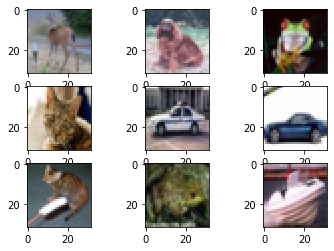

['horse', 'automobile', 'airplane', 'airplane', 'automobile', 'automobile', 'ship', 'automobile', 'ship']


In [58]:
#visualise test results

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

show_imgs(x_test[100:109])
 
#true value of labels
labels =  ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
 
indices = np.argmax(model.predict(x_test[100:109]),1)
print ([labels[x] for x in indices])

# Analyze Permormance

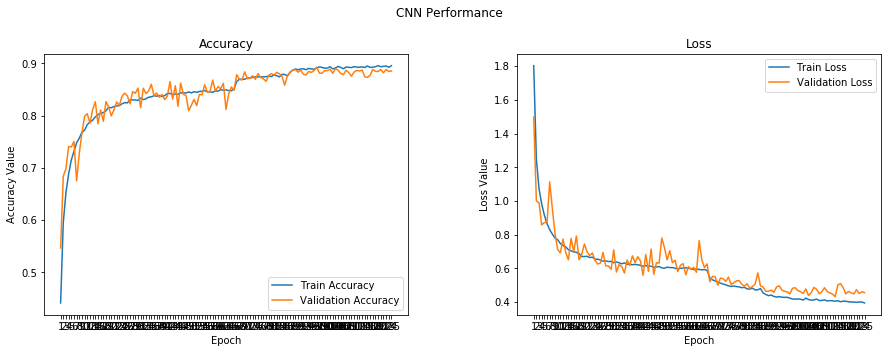

In [60]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
t = f.suptitle('CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epochs = list(range(1,125+1))
ax1.plot(epochs, history.history['accuracy'], label='Train Accuracy')
ax1.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(epochs)
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epochs, history.history['loss'], label='Train Loss')
ax2.plot(epochs, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(epochs)
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")